In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import bitfinex
from datetime import datetime
import time



# ML methods
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error


import math
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from keras.callbacks import LearningRateScheduler
from keras.metrics import RootMeanSquaredError
from sklearn.linear_model import LinearRegression


In [4]:
api_v1 = bitfinex.bitfinex_v1.api_v1()
pairs = api_v1.symbols()
pairs

No keys, only access to public API functions


['btcusd',
 'ltcusd',
 'ltcbtc',
 'ethusd',
 'ethbtc',
 'etcbtc',
 'etcusd',
 'rrtusd',
 'zecusd',
 'zecbtc',
 'xmrusd',
 'xmrbtc',
 'dshusd',
 'dshbtc',
 'btceur',
 'btcjpy',
 'xrpusd',
 'xrpbtc',
 'iotusd',
 'iotbtc',
 'ioteth',
 'eosusd',
 'eosbtc',
 'eoseth',
 'sanusd',
 'omgusd',
 'omgbtc',
 'omgeth',
 'neousd',
 'neobtc',
 'neoeth',
 'etpusd',
 'etpbtc',
 'qtmusd',
 'qtmbtc',
 'edousd',
 'btgusd',
 'btgbtc',
 'datusd',
 'gntusd',
 'sntusd',
 'ioteur',
 'batusd',
 'mnausd',
 'mnabtc',
 'funusd',
 'zrxusd',
 'zrxbtc',
 'zrxeth',
 'trxusd',
 'trxbtc',
 'trxeth',
 'repusd',
 'repbtc',
 'btcgbp',
 'etheur',
 'ethjpy',
 'ethgbp',
 'neoeur',
 'neojpy',
 'neogbp',
 'eoseur',
 'eosjpy',
 'eosgbp',
 'iotjpy',
 'iotgbp',
 'requsd',
 'lrcusd',
 'waxusd',
 'daiusd',
 'daibtc',
 'daieth',
 'bftusd',
 'antusd',
 'antbtc',
 'anteth',
 'stjusd',
 'xlmusd',
 'xlmbtc',
 'xlmeth',
 'xvgusd',
 'mkrusd',
 'kncusd',
 'kncbtc',
 'lymusd',
 'utkusd',
 'veeusd',
 'zcnusd',
 'essusd',
 'iqxusd',
 'zilusd',

In [51]:
def fetch_data(start=1640991600000, stop=1651356000000, symbol='btcusd', interval='1D', step=86400000):
    # Create api instance
    api_v2 = bitfinex.bitfinex_v2.api_v2()
    intervals_dict = {"1m": 60000, "5m": 300000, "15m": 900000, "30m": 1800000, "1h": 3600000, "3h": 10800000, "6h": 21600000, "12h": 43200000, "1D": 86400000, "7D": 604800000, "14D": 1209600000, "1M": 2628000000}
    step = intervals_dict[interval] * 1000
    data = []
    names = ['time', 'open', 'close', 'high', 'low', 'volume']

    if stop > time.time() * 1000: # stop value can't be higher than datetime.now()
        stop = datetime.now()
        stop = time.mktime(stop.timetuple()) * 1000
    if stop - start > step: # if data requested > 1000 * interval
        while start < stop:
            if start + step > stop: # if start + 1000 * interval > stop ==> stop = now
                end = datetime.now()
                end = time.mktime(end.timetuple()) * 1000
            else:
                end = start + step
            #print(datetime.fromtimestamp(start / 1000), datetime.fromtimestamp(end / 1000))
            res = api_v2.candles(symbol=symbol, interval=interval, start=start, end=end)
            data.extend(res)
            start += step
            time.sleep(1)
    else:
        res = api_v2.candles(symbol=symbol, interval=interval, start=start, end=stop)
        data.extend(res)
    #print(data)

    # Modify data to send back a clean DataFrame
    df = pd.DataFrame(data, columns=names)
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df = df.sort_values(by='time')
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    df.rename(columns={'time':'date'}, inplace=True)
    return df

In [52]:
pair = 'egld:usd'
interval = '1h'

t_start = datetime(2020, 5, 13, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

t_stop = datetime(2023, 1, 1, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

In [53]:
df = fetch_data(start=t_start, stop=t_stop, symbol=pair, interval=interval)
df

No keys, only access to public API functions


,date,open,close,high,low,volume
0,2020-09-10 10:00:00,22.000,15.411,22.000,9.888,1460.870000
1,2020-09-10 11:00:00,15.373,15.278,15.373,15.278,1563.641000
2,2020-09-10 12:00:00,15.327,15.401,15.401,15.327,1290.066000
3,2020-09-10 13:00:00,15.355,15.309,15.355,15.276,1254.975800
4,2020-09-10 14:00:00,15.276,15.230,15.319,15.225,278.504858
...,...,...,...,...,...,...
14611,2022-05-14 11:00:00,86.373,86.548,87.065,85.612,317.191964
14612,2022-05-14 12:00:00,86.206,86.554,87.349,86.049,70.860189
14613,2022-05-14 13:00:00,86.697,85.747,86.826,85.747,225.505578
14614,2022-05-14 14:00:00,85.761,85.855,85.975,85.283,284.462395


In [28]:
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

In [29]:
def SplitData(Data, Date, lstm=0, X_scaler=X_scaler, y_scaler=y_scaler):

  index = Data.index[Data['date'] == Date][0]
  X = Data.drop(columns=['date', 'close'], axis=1).to_numpy()
  y = Data['close'].to_numpy()

  if lstm:
    X = X_scaler.fit_transform(np.array(X))
    y = y_scaler.fit_transform(np.array(y).reshape(-1,1))
  
    X_train = X[:index]
    y_train = y[:index]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    X_test = X[index:]
    y_test = y[index:]
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  else:
    X_train = X[:index]
    y_train = y[:index]
    X_test = X[index:]
    y_test = y[index:]

  return X_train, y_train, X_test, y_test

# Linear Regression

In [30]:
date = '2022-02-01'
X_train, y_train, X_test, y_test = SplitData(df, date)

## Test

In [31]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

LinearRegression()

In [32]:
linear_regression_train_predict=linear_regression_model.predict(X_train)
linear_regression_validation_predict=linear_regression_model.predict(X_test)

print("Train data prediction:", linear_regression_train_predict.shape)
print("Validation data prediction:", linear_regression_validation_predict.shape)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, linear_regression_validation_predict)))

Train data prediction: (12151,)
Validation data prediction: (2465,)
Mean Absolute Error - MAE : 0.5888514737504943


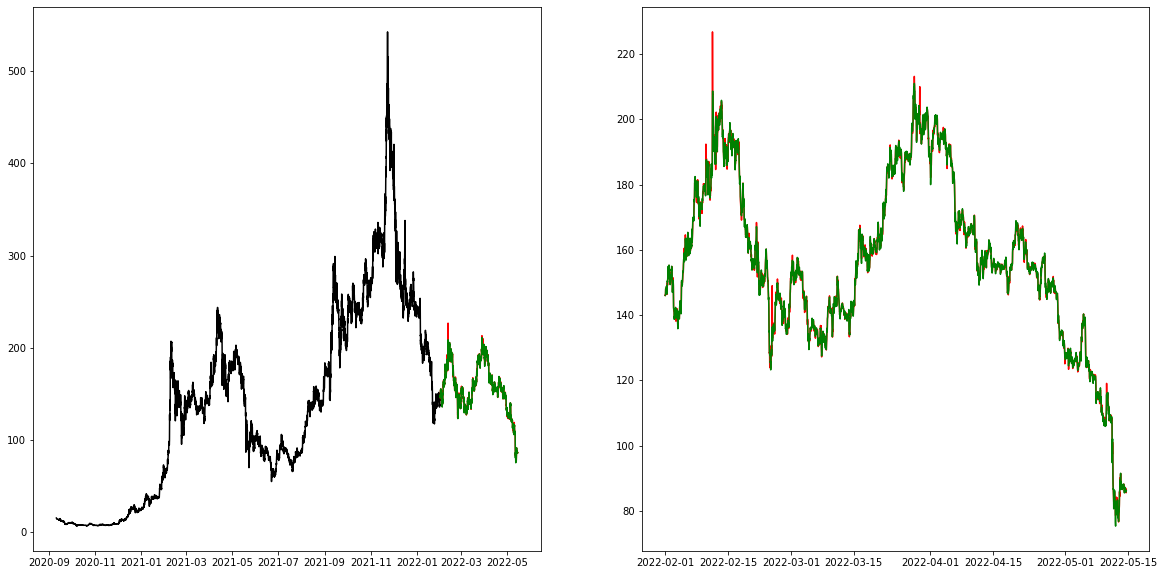

In [33]:
train_size = X_train.shape[0]
f,axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][train_size:], linear_regression_validation_predict, color='red')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[1].plot(df['date'][train_size:], linear_regression_validation_predict, color='red')
axs[1].plot(df['date'][train_size:], df['close'][train_size:], color='green')

## Tune

In [105]:
from sklearn.model_selection import GridSearchCV


lr_gs_model = LinearRegression()

# parameters that we will try to tune
params_lr_gs = {
    'n_jobs': range(1, 1000),
}

param_search = GridSearchCV( estimator=lr_gs_model, param_grid=params_lr_gs,
                verbose=1)
                
param_search.fit(X_train, y_train)

best_score = param_search.best_score_
best_params = param_search.best_params_

print(f'Best accuracy: {best_score} was obtained with parameters: {best_params}')

Fitting 5 folds for each of 999 candidates, totalling 4995 fits
Best accuracy: 0.983420617174662 was obtained with parameters: {'n_jobs': 1}


In [106]:
lr_final_model = LinearRegression(**best_params)
lr_final_model.fit(X_train, y_train)

LinearRegression(n_jobs=1)

In [107]:
lr_final_train_predict=lr_final_model.predict(X_train)
lr_final_validation_predict=lr_final_model.predict(X_test)

print("Train data prediction:", lr_final_train_predict.shape)
print("Validation data prediction:", lr_final_validation_predict.shape)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, lr_final_validation_predict)))

Train data prediction: (509,)
Validation data prediction: (102,)
Mean Absolute Error - MAE : 3.507049006824941


NameError: name 'lr_final_validation_predict' is not defined

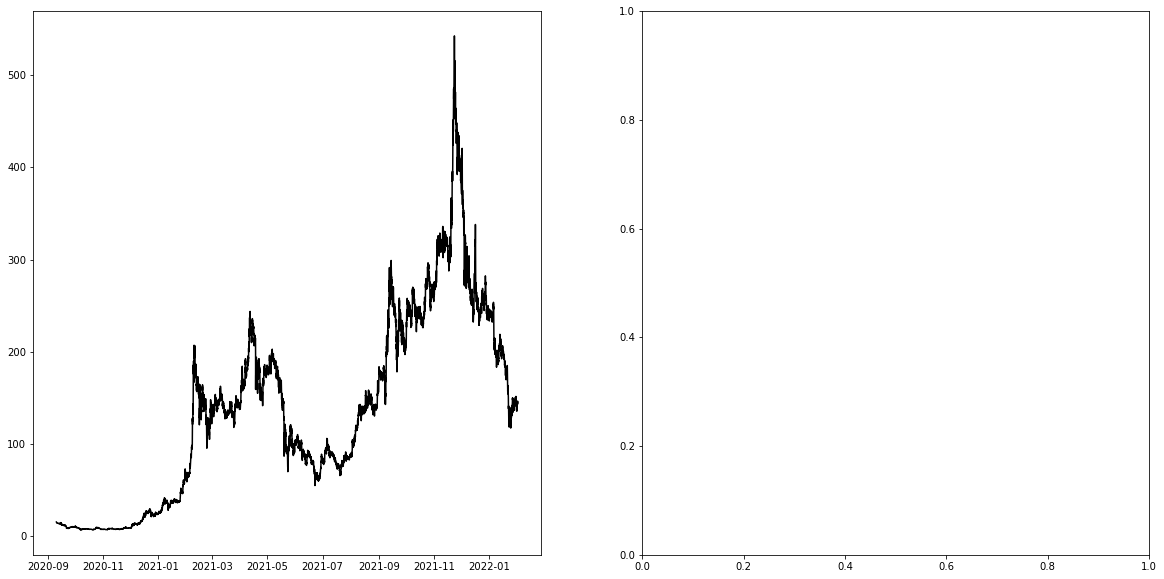

In [47]:
train_size = X_train.shape[0]
f,axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][train_size:], lr_final_validation_predict, color='red')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[1].plot(df['date'][train_size:], lr_final_validation_predict, color='red')
axs[1].plot(df['date'][train_size:], df['close'][train_size:], color='green')

# LSTM

In [34]:
date = '2022-02-01'
X_train, y_train, X_test, y_test = SplitData(df, date, lstm=1)

In [35]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12151, 4, 1), (12151, 1), (2465, 4, 1), (2465, 1))

## Test

In [36]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [37]:
np.random.seed(42)
lstm_neurons = 100
epochs = 50
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [38]:
lstm_model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [39]:
hist = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
380/380 [==============================] - 5s 7ms/step - loss: 0.0030 - val_loss: 1.1645e-05
Epoch 2/50
380/380 [==============================] - 2s 6ms/step - loss: 2.9851e-04 - val_loss: 1.2292e-05
Epoch 3/50
380/380 [==============================] - 2s 5ms/step - loss: 2.5930e-04 - val_loss: 3.4843e-05
Epoch 4/50
380/380 [==============================] - 2s 6ms/step - loss: 2.3137e-04 - val_loss: 1.4065e-05
Epoch 5/50
380/380 [==============================] - 2s 5ms/step - loss: 2.2502e-04 - val_loss: 5.7704e-06
Epoch 6/50
380/380 [==============================] - 2s 5ms/step - loss: 2.0418e-04 - val_loss: 6.2928e-06
Epoch 7/50
380/380 [==============================] - 2s 5ms/step - loss: 1.8756e-04 - val_loss: 8.0011e-05
Epoch 8/50
380/380 [==============================] - 2s 5ms/step - loss: 1.7901e-04 - val_loss: 8.4090e-06
Epoch 9/50
380/380 [==============================] - 2s 5ms/step - loss: 1.6016e-04 - val_loss: 2.2392e-05
Epoch 10/50
380/380 [===========

In [40]:
# make predictions
train_prediction = lstm_model.predict(X_train)
test_prediction = lstm_model.predict(X_test)

# invert predictions

# create empty table with 4 fields
train_prediction_dataset_like, test_prediction_dataset_like = np.zeros(shape=(len(train_prediction), X_train.shape[1])), np.zeros(shape=(len(test_prediction), X_test.shape[1]))
# put the predicted values in the right field
train_prediction_dataset_like[:,0], test_prediction_dataset_like[:,0] = train_prediction[:,0], test_prediction[:,0]
# inverse transform and then select the right field
train_prediction, test_prediction = X_scaler.inverse_transform(train_prediction_dataset_like)[:,0], X_scaler.inverse_transform(test_prediction_dataset_like)[:,0]
train_prediction, test_prediction = train_prediction.reshape(-1,1), test_prediction.reshape(-1,1)

y_train = y_scaler.inverse_transform(y_train)
y_test = y_scaler.inverse_transform(y_test)

In [41]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_prediction)))
print("Train data MSE: ", mean_squared_error(y_train,train_prediction))
print("Train data MAE: ", mean_absolute_error(y_train,train_prediction))
print("Train data explained variance regression score:", explained_variance_score(y_train, train_prediction))
print("Train data R2 score:", r2_score(y_train, train_prediction))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_prediction)))
print("Test data MSE: ", mean_squared_error(y_test,test_prediction))
print("Test data MAE: ", mean_absolute_error(y_test,test_prediction))
print("Test data explained variance regression score:", explained_variance_score(y_test, test_prediction))
print("Test data R2 score:", r2_score(y_test, test_prediction))

Train data RMSE:  2.6295515385420214
Train data MSE:  6.914541293848711
Train data MAE:  2.2097911390340146
Train data explained variance regression score: 0.9995902873104195
Train data R2 score: 0.9993371678394747
-------------------------------------------------------------------------------------
Test data RMSE:  1.5998097390800539
Test data MSE:  2.5593912012553903
Test data MAE:  1.3335345836937327
Test data explained variance regression score: 0.9979104577294253
Test data R2 score: 0.9962127841488423


In [42]:
train_size = X_train.shape[0]

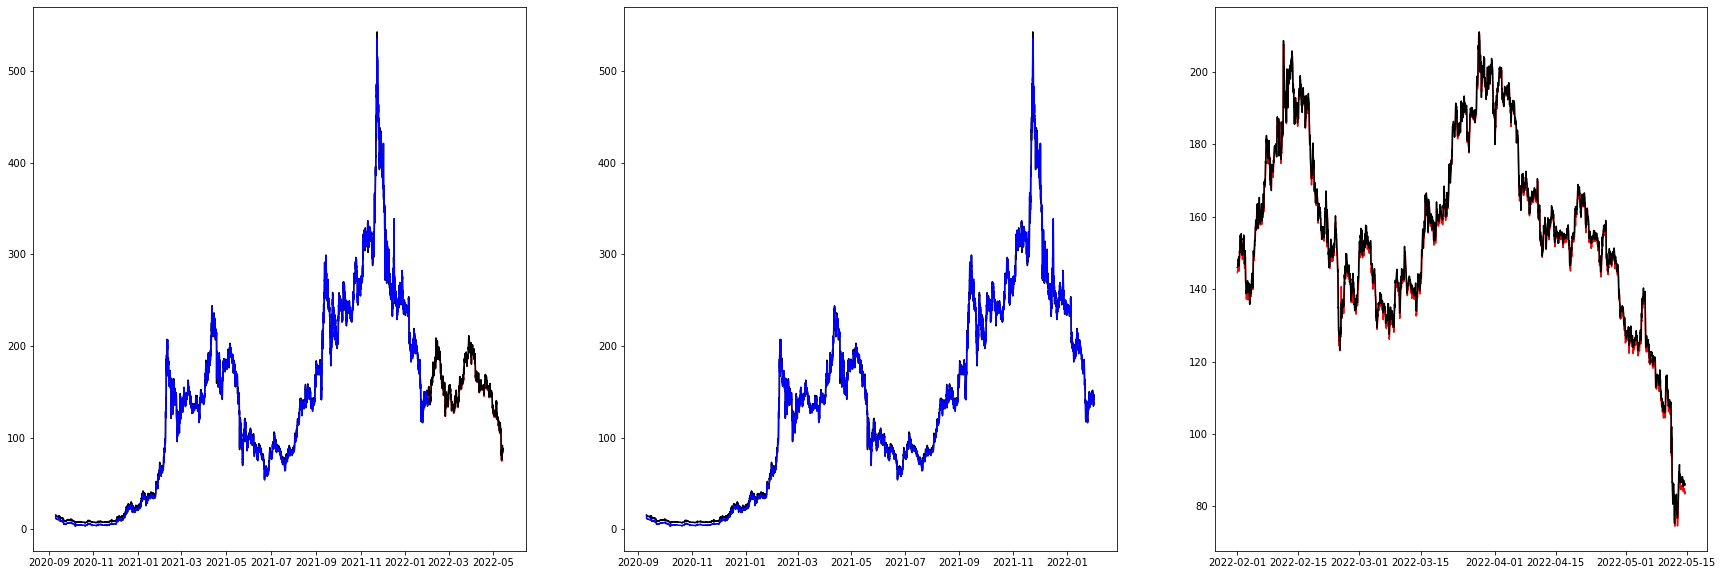

In [43]:
f,axs = plt.subplots(1,3,figsize=(30,10))

axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][:train_size], train_prediction, color='blue')
axs[0].plot(df['date'][train_size:], test_prediction, color='red')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='black')
axs[1].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[1].plot(df['date'][:train_size], train_prediction, color='blue')
axs[2].plot(df['date'][train_size:], test_prediction, color='red')
axs[2].plot(df['date'][train_size:], df['close'][train_size:], color='black')

plt.show()

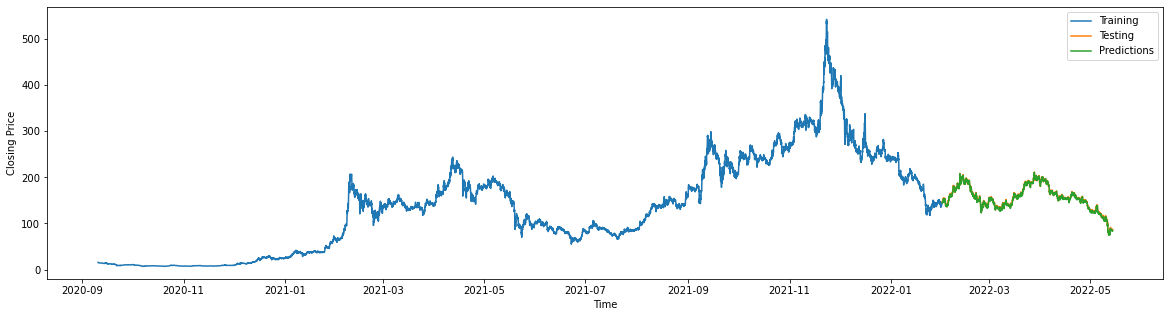

In [44]:
plt.figure(figsize=(20, 5))
plt.plot(df['date'][df['date'] < date], y_train, label = 'Training')
plt.plot(df['date'][df['date'] >= date], y_test, label = 'Testing')
plt.plot(df['date'][df['date'] >= date], test_prediction, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

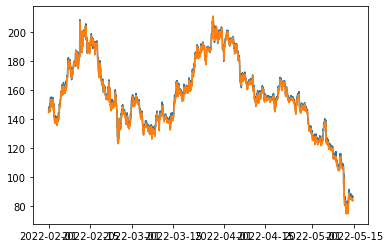

In [45]:
plt.plot(df['date'][df['date'] >= date], df['close'][df['date'] >= date], label = 'Testing')
plt.plot(df['date'][df['date'] >= date], test_prediction, label = 'Predictions')

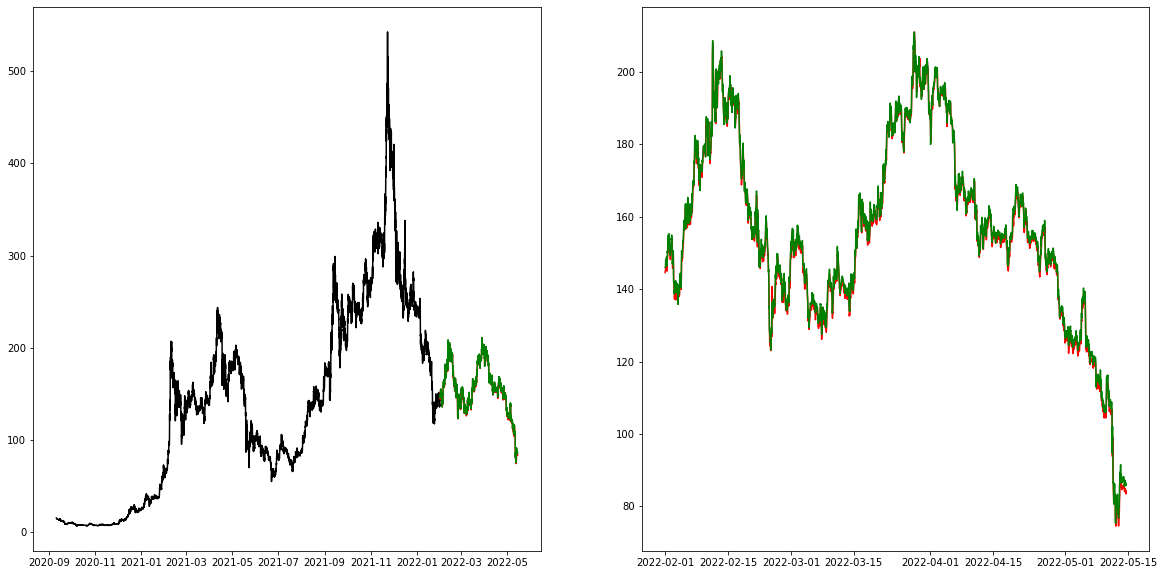

In [46]:
f,axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][train_size:], test_prediction, color='red')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[1].plot(df['date'][train_size:], test_prediction, color='red')
axs[1].plot(df['date'][train_size:], df['close'][train_size:], color='green')